In [2]:
# change to "%matplotlib notebook" to get interative plot with zoom functionalities 
%matplotlib inline
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mat4py import loadmat
from numpy import convolve as conv
from scipy.signal import *
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from IPython.display import display, Math
np.set_printoptions(formatter={'float_kind':'{0:.4f}'.format})
CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Primeira Questão

In [22]:
Ha = np.array([-.3327, .8069, -.4599, -.1350, .0854, .0352])
Hb = np.array([.0352, -.0854, -.1350, .4599, .8069, .3327])
Ga = np.array([.3327, .8069, .4599, -.1350, -.0854, .0352])
Gb = np.array([.0352, .0854, -.1350, -.4599, .8069, -.3327])

## d)

Para classificar os filtros acima em passa-baixa, passa-faixa, rejeita-faixa ou passa-alta, fazemos $H(z) = H(e^{j\omega})$ e em seguida criamos um vetor de frequências (em radianos) para plotar o gráfico da magnitude da resposta em frequência. Assim, a partir desse gráfico é possível definir o tipo de cada filtro.

In [23]:
n = 10000
jw_vec = np.tile(np.arange(6)*-1j, (n,1))
w_vec = np.linspace(0, 3, 10000)
jw_array = jw_vec * w_vec[:, np.newaxis]
ejw_array = np.power(np.e, jw_array)
Ha_freqz = np.matmul(ejw_array, Ha)
Hb_freqz = np.matmul(ejw_array, Hb)
Ga_freqz = np.matmul(ejw_array, Ga)
Gb_freqz = np.matmul(ejw_array, Gb)

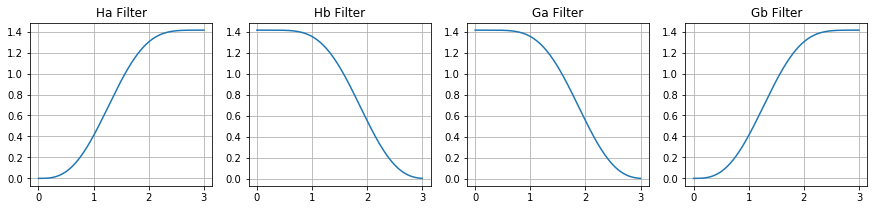

In [24]:
plt.figure(figsize=[15,3])
plt.subplot(141)
plt.title("Ha Filter")
plt.plot(w_vec, np.abs(Ha_freqz))
plt.grid()
plt.subplot(142)
plt.title("Hb Filter")
plt.plot(w_vec, np.abs(Hb_freqz))
plt.grid()
plt.subplot(143)
plt.title("Ga Filter")
plt.plot(w_vec, np.abs(Ga_freqz))
plt.grid()
plt.subplot(144)
plt.title("Gb Filter")
plt.plot(w_vec, np.abs(Gb_freqz))
plt.grid()
plt.show()

Analisando os gráficos acima, determinamos que os filtros são:
- Ha -> Passa-alta
- Hb -> Passa baixa
- Ga -> Passa baixa
- Gb -> Passa alta

Assim, a configuração adequada dos filtros no banco QMF seria:

![image](images/qmf_1d.png)

**Condições para reconstrução perfeita**

- Condição 1:

$$H_b(-z)G_a(z) + H_a(-z)G_b(z) = 0$$

Como a multiplicação polinomial pode ser realizada por meio de uma convolução, temos que:

$$H_b(-z)*G_a(z) + H_a(-z)*G_b(z) = 0$$

Podemos trabalhar os filtros como vetores, de forma que:

In [25]:
Ha_ = np.array(Ha)
Ha_[1:len(Ha_):2] = -Ha_[1:len(Ha_):2]
Hb_ = np.array(Hb)
Hb_[1:len(Hb_):2] = -Hb_[1:len(Hb_):2]
print("H_b(z) = {}".format(Hb))
print("H_a(z) = {}".format(Ha))
print("H_b(-z) = {}".format(Hb_))
print("H_a(-z) = {}".format(Ha_))

H_b(z) = [0.0352 -0.0854 -0.1350 0.4599 0.8069 0.3327]
H_a(z) = [-0.3327 0.8069 -0.4599 -0.1350 0.0854 0.0352]
H_b(-z) = [0.0352 0.0854 -0.1350 -0.4599 0.8069 -0.3327]
H_a(-z) = [-0.3327 -0.8069 -0.4599 0.1350 0.0854 -0.0352]


Aplicando a convolução temos que:

In [26]:
Hb_Ga = conv(Hb_, Ga)
Ha_Gb = conv(Ha_, Gb)
print("H_b(-z)*G_a(z) = {}".format(Hb_Ga))
print("H_a(-z)*G_b(z) = {}".format(Ha_Gb))

H_b(-z)*G_a(z) = [0.0117 0.0568 0.0402 -0.2274 -0.1793 0.3411 0.1793 -0.2274 -0.0402 0.0568
 -0.0117]
H_a(-z)*G_b(z) = [-0.0117 -0.0568 -0.0402 0.2274 0.1793 -0.3411 -0.1793 0.2274 0.0402
 -0.0568 0.0117]


Finalmente, podemos somar os polinômios, obtendo:

In [27]:
def poly_sum(x, y):
    x1 = np.zeros(max(len(x), len(y)))
    y1 = np.copy(x1)
    x1[:len(x)] = x
    y1[:len(y)] = y
    z = x1 + y1
    return z
alias_term = poly_sum(Hb_Ga, Ha_Gb)
print("H_b(-z)*G_a(z) + H_a(-z)*G_b(z) = {}".format(alias_term))

H_b(-z)*G_a(z) + H_a(-z)*G_b(z) = [0.0000 0.0000 0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000 -0.0000 0.0000
 0.0000]


Podemos considerar valores inferiores a 1e-4 como erro numérico e concluir que a primeira condição foi satisfeita.

In [28]:
tol = 1e-4
alias_term_tol = np.where(np.abs(alias_term) < tol, 0, alias_term)
print("H_b(-z)*G_a(z) + H_a(-z)*G_b(z) = {}".format(alias_term_tol))
cond1 = np.sum(alias_term_tol) == 0
if cond1:
    print("Primeira condição satisfeita!")
else:
    print("Primeira condição não satisfeita")

NameError: name 'cond1_tol' is not defined

- Condição 2:

$$\frac{1}{2}[H_b(z)G_a(z) + H_a(z)G_b(z)] = Az^{-d}$$

Novamente, como a multiplicação polinomial pode ser realizada por meio de uma convolução, temos que:

$$\frac{1}{2}[H_b(z)*G_a(z) + H_a(z)*G_b(z)] = Az^{-d}$$

Aplicando a convolução temos que:

In [29]:
HbGa = conv(Hb, Ga)
HaGb = conv(Ha, Gb)
print("H_b(z)*G_a(z) = {}".format(HbGa))
print("H_a(z)*G_b(z) = {}".format(HaGb))

H_b(z)*G_a(z) = [0.0117 -0.0000 -0.0976 0.0000 0.5860 1.0000 0.5860 0.0000 -0.0976 -0.0000
 0.0117]
H_a(z)*G_b(z) = [-0.0117 -0.0000 0.0976 0.0000 -0.5860 1.0000 -0.5860 0.0000 0.0976
 -0.0000 -0.0117]


Por fim, realiza-se a soma polinomial já levando em consideração o desconto da tolerância definida para erro numérico (1e-4)

In [30]:
lti_term = poly_sum(HbGa, HaGb)/2
lti_term_tol = np.where(np.abs(lti_term) < tol, 0, lti_term)
print("H_b(z)*G_baz) + H_a(z)*G_b(z) = {}".format(lti_term_tol))
k = np.where(lti_term_tol != 0)
cond2 = len(k) == 1
if cond2:
    print("Segunda condição satisfeita!")
else:
    print("Segunda condição não satisfeita")

H_b(z)*G_baz) + H_a(z)*G_b(z) = [0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.0000]
Segunda condição satisfeita!


Além disso, podemos determinar os valores de A e d como:

In [31]:
A = int(round(lti_term_tol[int(k[0][0])]))
d = int(k[0][0])
print("A =", A)
print("d =", d)

A = 1
d = 5


## e)

Para que a decomposição seja ortogonal o produto interno dos filtros de decomposição deve ser igual a zero.

In [631]:
np.sum(Ha*Hb)

-5.204170427930421e-18

Considerando a ordem de 1e-18 como erro númerico, podemos considerar que os filtros de decomposição são ortogonais

## h)

Primeiro define-se as funções para realizar e plotar os filtros iterados:

In [32]:
def downsample(x, factor):
    x = x[:len(x):factor]
    return x
def upsample(x, factor):
    y = np.zeros(len(x)*factor)
    y[:len(y):factor] = x
    return y

def filter_iterator(h0, h1, levels):
    h0 = np.array(h0)
    h1 = np.array(h1)
    h = [0] * (levels+1)
    h[levels] = h1
    aux = np.copy(h0)
    for n in range(levels, 1, -1):
        h_ = upsample(h[n], 2)
        h_ = h_[:len(h_) - 1]
        h[n-1] = conv(h_, h0)
        aux = upsample(aux, 2)
        aux = aux[:len(aux) - 1]
        aux = conv(aux, h0)
    h[0] = aux
    return h

def plot_iterated_filters(h, h_names):
    n_filters = len(h)
    fig = plt.figure(figsize=[13,4])
    ax1 = fig.add_subplot(121)
    for i in range(n_filters):
        w, h_mag = freqz(h[i])
        plt.plot(w, abs(h_mag), label = h_names[i])
    plt.ylabel('Magnitude')
    plt.xlabel('Frequencies [rad/sample]')
    plt.grid()
    plt.legend()

    ax2 = fig.add_subplot(122)
    for i in range(n_filters):
        w, h_mag = freqz(h[i])
        angles = np.unwrap(np.angle(h_mag))
        plt.plot(w, angles, label = h_names[i])
    plt.ylabel('Angle (radians)')
    plt.xlabel('Frequencies [rad/sample]')
    plt.grid()
    plt.legend()
    plt.show()

Para o caso de 3 níveis:

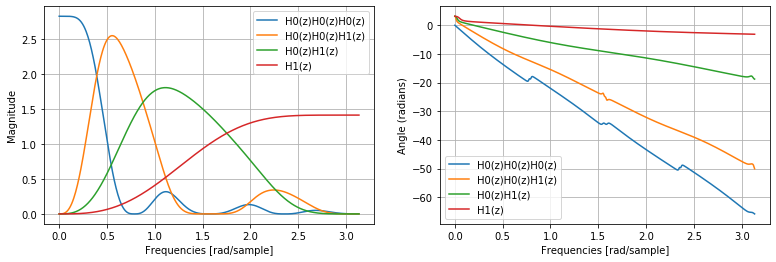

In [33]:
h3n = filter_iterator(Hb, Ha, 3)
h3n_names = ["H0(z)H0(z)H0(z)", "H0(z)H0(z)H1(z)", "H0(z)H1(z)", "H1(z)"]
plot_iterated_filters(h3n, h3n_names)

Para o caso de 4 níveis:

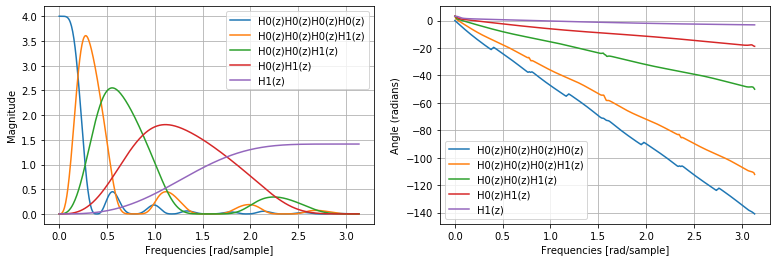

In [34]:
h4n = filter_iterator(Hb, Ha, 4)
h4n_names = ["H0(z)H0(z)H0(z)H0(z)", "H0(z)H0(z)H0(z)H1(z)", "H0(z)H0(z)H1(z)", "H0(z)H1(z)", "H1(z)"]
plot_iterated_filters(h4n, h4n_names)

## i)

Como é possível observar pela resposta em frequência dos filtros iterados, o filtros para altas frequências possuem uma baixa precisão em frequência e, consequentemente, uma alta precisão no tempo. Conforme as frequências filtradas vão diminuindo, a precisão em frequência vai aumentando e, com isso, a precisão no tempo diminui.

## j)

Cada conjunto permite uma representação diferente da informação, com diferentes bandas passantes, ripple, fase, etc. Isso faz com que cada conjunto possua vantagens e desvantagens em comparação aos demais, não havendo então um único filtro superior em todos os casos. Assim, a definição do filtro é comumente feita de acordo com a aplicação e muitas vezes de maneira empírica.

## k)

# Segunda Questão

## a)

Primeiro define-se as funções para plotar a transformada de Fourier do sinal na frequência

In [35]:
def plotFFTSignal(signal, fs):
    """
    This function plots a signal power espectrum density (PSD)

    Parameters
    ----------
    esignal : numpy array (signal_length,)
        The signal as a row vector
    fs : integer
        The signal sampling rate in Hertz
    """
    N = len(signal) # store the number of sample in the signal
    # create a frequency vector to match the frequency index for each sample
    f = np.linspace(0, fs, N)
    # apply the fft transform to the signal normalized by the signal length
    signal_fft = np.fft.fft(signal)/N
    # calculate the PSB by elevating the signal magnitude to the second power
#     psd = np.power(np.abs(signal_fft), 2)
    signal_fft = np.abs(signal_fft)
    # configure plot
    plt.figure() 
    # plot only the positive frequencies
    plt.plot(f[:N // 2], signal_fft[:N // 2])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

Para o sinal de ECG

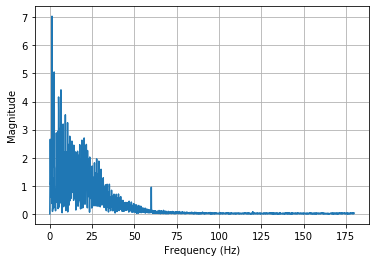

In [36]:
data_ecg_1 = loadmat('sinais_prova_1/ecg_1.mat')
ecg_1_fs = data_ecg_1["fs"]
ecg_1_sig = np.array(data_ecg_1["x"])[:, 0]
ecg_1_sig_ac = ecg_1_sig - np.mean(ecg_1_sig)
plotFFTSignal(ecg_1_sig_ac, ecg_1_fs)

Para o sinal de EMG

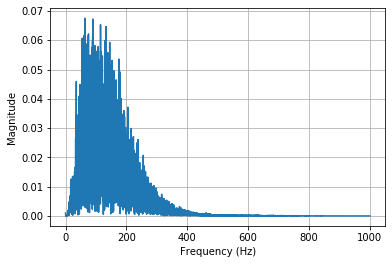

In [37]:
data_emg_1 = loadmat('sinais_prova_1/emg_1.mat') 
emg_1_fs = data_emg_1["fs"]
emg_1_sig = np.array(data_emg_1["x"])[:, 0]
plotFFTSignal(emg_1_sig, emg_1_fs)

## b)

Com base nas resposta em frequência o sinal de EMG possui uma banda mais larga com grande parte da energia até 200 Hz enquanto o sinal de ECG está mais concentrado em baixas frequências (em torno de 25 Hz). Dessa forma, conclui-se que o sinal de ECG possui oscilações mais rápidas enquanto o sinal de ECG possui oscilações mais lentas.

## c)

Primeiro define-se a função para o cálculo da energia por intervalo

In [158]:
def energy_in_interval(signal, fs, lower_band, upper_band, get_results=False):
    N = len(signal)
    signal_fft = np.fft.fft(signal)/N
    signal_fft_pos = np.abs(signal_fft[:N // 2])
    f = np.linspace(0, fs, N)
    f_pos = f[:N // 2]
    lower_band_idx = round(lower_band * N/fs)
    upper_band_idx = round(upper_band * N/fs)
    signal_fft_interval = signal_fft_pos[lower_band_idx:upper_band_idx+1]
    f_interval = f_pos[lower_band_idx:upper_band_idx+1]

    E_total = np.sum(np.power(np.abs(signal_fft_pos), 2))
    E_band = np.sum(np.power(np.abs(signal_fft_interval), 2))
    E_pct = 100*(E_band/E_total)
    if get_results:
        return E_pct
    else:
        print("Total energy = {0:.2f}".format(E_total))
        print("Band energy = {0:.2f}".format(E_band))
        print("Band energy percentage = {0:.2f}%".format(E_pct))

        # configure plot
        plt.figure() 
        # plot only the positive frequencies
        plt.plot(f_pos, signal_fft_pos, label="Signal FFT")
        plt.plot(f_interval, signal_fft_interval, label="Signal FFT from {} to {} Hz".format(lower_band, upper_band))
        plt.legend()
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.show()

Percentual de energia na banda de 2 a 40 Hz para o ECG:

Total energy = 724.97
Band energy = 640.30
Band energy percentage = 88.32%


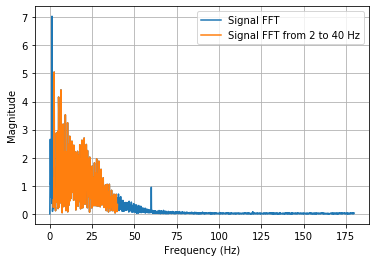

In [39]:
energy_in_interval(ecg_1_sig_ac, ecg_1_fs, lower_band=2, upper_band=40)

## d)

Percentual de energia na banda de 2 a 150 Hz para o EMG:

Total energy = 1.19
Band energy = 0.88
Band energy percentage = 73.86%


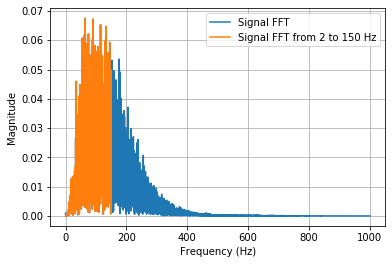

In [40]:
energy_in_interval(emg_1_sig, emg_1_fs, lower_band=2, upper_band=150)

## e)

- A linha de base encontrada no sinal de ECG está relacionada a interferência da respiração no sinal captado pelo eletrodo. No geral, pode-se considerar que a respiração tem uma frequência menor que 1 Hz. Esse ruído contamina o ECG pois trata-se de um sinal bioelétrico muscular que também é coletado pelo eletrodo do ECG.
- O outro ruído não natural está relacionado à interferência da rede elétrica, como é possível observar pelo pico em torno de 60 Hz na FFT do sinal. Esse ruído pode contaminar o sinal de ECG por contato físico com a rede elétrica pela pessoa, pelo eletrodo ou pelo equipamento de aquisição, ou ainda pela captação da radiação eletromagnética gerada pela rede em partes do sistema que funcionando como antenas.

## f)

Para determinar os índices k da DTF para serem filtrados podemos usar a seguinte relação:
$$k = \frac{f_{Hz}N_{fft}}{f_s}$$
onde $f_{Hz}$ é a frequência em Hz, $N_{fft}$ é o número de pontos da FFT e $f_s$ é a frequência de amostragem do sinal. Nesse caso, estamos considerando $N_fft$ igual ao tamanho do sinal $N$

Assim, para o primeiro ruído (< 1Hz), podemos anular os seguintes índices k:

In [41]:
f_lb = 1
k_1Hz = round(f_lb * len(ecg_1_sig)/ecg_1_fs)
print("Remove all indexes {} <= k <= {}".format(-k_1Hz, k_1Hz))

Remove all indexes -10 <= k <= 10


Para encontrar os índices n no vetor de coeficientes da fft devemos considerar a forma com que o a fft é formada (frequências negativas ao final do vetor). Dessa forma podemos eliminar os índices n <= 10 e n >= N - 10

Já no segundo caso, podemos anular apenas o ruído de 60 Hz, logo:

In [42]:
f_nn = 60
k_60Hz = round(f_nn * len(ecg_1_sig)/ecg_1_fs)
print("Remove the index k = {}".format(k_60Hz))

Remove the index k = 600


Removendo os índice podemos observar a transformada de Fourier resultante

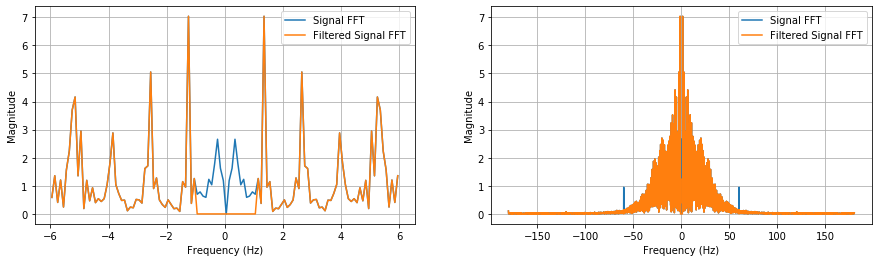

In [43]:
signal = np.copy(ecg_1_sig_ac)
fs = ecg_1_fs
N = len(signal) # store the number of sample in the signal
# create a frequency vector to match the frequency index for each sample
f = np.linspace(-fs/2, fs/2, N)
# apply the fft transform to the signal normalized by the signal length
signal_fft = np.fft.fft(signal)/N

signal_fft_filtered = np.copy(signal_fft)
signal_fft_filtered[:k_1Hz+1] = 0
signal_fft_filtered[N-k_1Hz:] = 0
signal_fft_filtered[k_60Hz] = 0
signal_fft_filtered[N-k_60Hz] = 0

# configure plot
plt.figure(figsize=[15,4]) 
plt.subplot(121)
# plot only the positive frequencies
adj = 50
plt.plot(f[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], 
         np.fft.fftshift(np.abs(signal_fft))[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], label="Signal FFT")
plt.plot(f[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], 
         np.fft.fftshift(np.abs(signal_fft_filtered))[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], label="Filtered Signal FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.subplot(122)
# plot only the positive frequencies
plt.plot(f, np.fft.fftshift(np.abs(signal_fft)), label="Signal FFT")
plt.plot(f, np.fft.fftshift(np.abs(signal_fft_filtered)), label="Filtered Signal FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.show()

Aplicando a transformada inversa de Fourier podemos comparar o sinal filtrado com o original

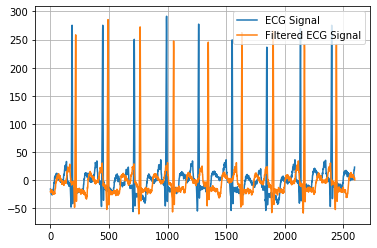

In [633]:
signal_filtered = N*np.fft.ifft(signal_fft_filtered)
plt.figure()
plt.plot(signal, label="ECG Signal")
plt.plot(np.real(signal_filtered), label="Filtered ECG Signal")
plt.grid()
plt.legend()
plt.show()

## g)

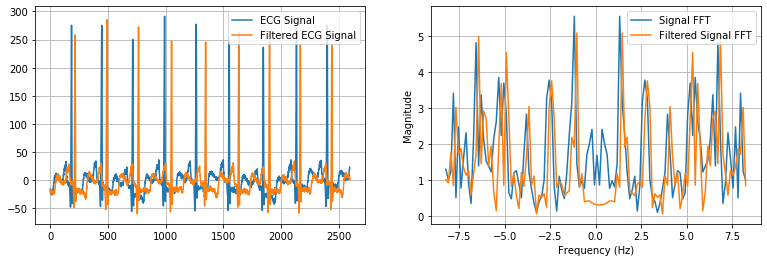

In [628]:
f_lb = 1

filter_order = 1000
signal = np.copy(ecg_1_sig_ac)
fs = ecg_1_fs
N = len(signal) # store the number of sample in the signal

fir_window = firwin(filter_order+1, f_lb, window='hamming', fs=ecg_1_fs, pass_zero=False)
signal_filtered = lfilter(b=fir_window, a=1, x=signal)[len(fir_window) - 1:]
signal = signal[:N - len(fir_window) - 1]
N = len(signal)

f = np.linspace(-fs/2, fs/2, N)
# apply the fft transform to the signal normalized by the signal length
signal_fft = np.fft.fft(signal)/N
signal_fft_filtered = np.fft.fft(signal_filtered)/N

plt.figure(figsize=[13,4])
plt.subplot(121)
plt.plot(signal, label="ECG Signal")
plt.plot(signal_filtered, label="Filtered ECG Signal")
plt.legend()
plt.grid()
plt.subplot(122)
# plot only the positive frequencies
adj = 50
plt.plot(f[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], 
         np.fft.fftshift(np.abs(signal_fft))[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], label="Signal FFT")
plt.plot(f[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], 
         np.fft.fftshift(np.abs(signal_fft_filtered))[N//2 - k_1Hz - adj:N//2 + k_1Hz + adj], label="Filtered Signal FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.show()

# Terceira Questão

# Quarta Questão

# Quinta Questão

## a)

In [188]:
def getEEGSignals(set_name = 'A', signal_number = 1):
    sig_str = str(signal_number)
    sig_num = sig_str.zfill(3)
    dir_path = 'C:/Users/victo/OneDrive/Documentos/PSB/sinais_prova_1/sinais_eeg/set'
    if set_name == 'A':
        data_path = dir_path + set_name + '/Z' + sig_num + '.txt'
    if set_name == 'B':
        data_path = dir_path + set_name + '/O' + sig_num + '.txt'
    if set_name == 'C':
        data_path = dir_path + set_name + '/N' + sig_num + '.TXT' 
    if set_name == 'D':
        data_path = dir_path + set_name + '/F' + sig_num + '.txt' 
    if set_name == 'E':
        data_path = dir_path + set_name + '/S' + sig_num + '.txt' 
    data_output = np.loadtxt(data_path)
    return data_output

In [17]:
def plotSignal(signal, fs, t0=0, delta_t=-1, show_plot=True):
    """
    This function plots a signal for a given time interval.

    If no interval if given the whole signal will be plotted.

    If the interval exceeds the signal duration, 
    a warning will be printed in the terminal

    Parameters
    ----------
    signal : numpy array (signal_length,)
        The signal as a row vector
    fs : integer
        The signal sampling rate in Hertz
    t0 : float
        The time to begin plotting in seconds
    delta_t : float
        The duration of the signal to be plotted in seconds
    """
    if delta_t == -1: # if delta is -1 plot till the end of the signal
        # set delta to the duration of the signal minus t0
        delta_t = len(signal)*(1/fs) - t0 
    # calculate duration from num of samples and sampling rate
    duration = len(signal)*(1/fs) 
    # get input required duration
    calc_duration = t0 + delta_t 
    # check if required duration exceeds the real duration
    if calc_duration > duration: 
        print("Exceeded signal duration")
        return
    # get equivalent sample for the initial time
    n0 = int(round(t0*fs)) 
    # get equivalent sample for the final time
    n1 = n0 + int(round(delta_t*fs)) 
    # produce time vector to show plot in sec
    t = np.linspace(0, len(signal)/fs, len(signal))
    # configure plot for the signal
    if show_plot:
        plt.figure()
        plt.plot(t[n0:n1], signal[n0:n1])
        plt.ylabel("EEG amplitude")
        plt.xlabel("time (s)")
        plt.grid()
        plt.show()
    else:
        return t[n0:n1], signal[n0:n1]

In [91]:
def extract_windows(signal, fs):
    window_duration_seconds = 5
    window_overlap = 2.5
    N_window = round(window_duration_seconds * fs)
    window = np.hamming(N_window)
    l_inf = 0
    l_sup = l_inf + N_window
    num_windows=0
    signal_window_vec = []
    while(l_sup<=len(signal)):
        window_pad = np.zeros(len(signal))
        window_pad[l_inf:l_sup] = window
        signal_window = signal*window_pad
        signal_window_vec.append(signal_window[l_inf:l_sup])
        l_inf += round(window_overlap * fs)
        l_sup = l_inf + N_window
        num_windows+=1
    return signal_window_vec

In [154]:
def extract_features(signal, fs):
    N = len(signal)
    signal_fft = np.fft.fft(signal)/N
    signal_fft_pos = np.abs(signal_fft[:N // 2])
    f = np.linspace(0, fs, N)
    f_pos = f[:N // 2]
    psd = np.power(np.abs(signal_fft_pos), 2)
    freq_modal = f_pos[int(np.where(psd==max(psd))[0][0])]
    freq_mean = np.sum(psd*f_pos)/np.sum(psd)

    half_energy = np.sum(psd)/2
    f_idx = len(f_pos)//2
    freq_median = f_pos[f_idx]
    current_energy = np.sum(psd[:f_idx])
    if current_energy < half_energy:
        while(current_energy < half_energy):
            freq_median = f_pos[f_idx]
            current_energy = np.sum(psd[:f_idx])
            f_idx+=1
    elif current_energy > half_energy:
        while(current_energy > half_energy):
            freq_median = f_pos[f_idx]
            current_energy = np.sum(psd[:f_idx])
            f_idx-=1

    val_med_ret = np.mean(np.abs(signal))
    rms = np.sqrt(np.mean(np.power(signal, 2)))
    features = [freq_median, freq_mean, freq_modal, val_med_ret, rms]
    return np.array(features)

In [324]:
def extract_features_windows(signal, fs):
    i=0
    window_vec = extract_windows(signal, fs)
    features = extract_features(window_vec[i], fs)
    for i in range(1, len(window_vec)):
        features = features + extract_features(window_vec[i], fs)
    features = features/len(window_vec)
    return features

In [325]:
features_names = ["F Median", "F Mean", "F Modal", "V Med Ret", "RMS"]
eeg_signals_names = ["A", "B", "C", "D", "E"]
eeg_table1_df = pd.DataFrame(index=eeg_signals_names, columns=features_names)
for k in range(len(eeg_signals_names)):
    sig_type = eeg_signals_names[k]
    data_eeg_1 = getEEGSignals(sig_type, 1)
    eeg_1_fs = 173.61
    features = extract_features_windows(data_eeg_1, eeg_1_fs)
    eeg_table1_df.loc[sig_type, :] = features
eeg_table1_df

,F Median,F Mean,F Modal,V Med Ret,RMS
A,4.58054,6.50059,1.87727,18.5042,27.363
B,6.80824,7.46218,2.478,21.1671,31.0622
C,2.10254,2.85706,0,21.922,33.3189
D,0.100121,1.31254,0,17.7568,25.6782
E,7.15866,8.78728,3.47921,202.905,301.07


## b)

In [161]:
def extract_features2(signal, fs):
    bands = [[0, 4], [4, 7], [7, 15], [16, 31], [32, fs/2]]
    E_pct_vec = []
    for band in bands:
        E_pct = energy_in_interval(signal, fs, band[0], band[1], get_results=True)
        E_pct_vec.append(E_pct)
    return np.array(E_pct_vec)

In [332]:
def extract_features2_windows(signal, fs):
    i=0
    window_vec = extract_windows(signal, fs)
    features = extract_features2(window_vec[i], fs)
    for i in range(1, len(window_vec)):
        features = features + extract_features2(window_vec[i], fs)
    features = features/len(window_vec)
    return features

In [333]:
features_names = ["Delta", "Teta", "Alfa", "Beta", "Gama"]
eeg_signals_names = ["A", "B", "C", "D", "E"]
eeg_table2_df = pd.DataFrame(index=eeg_signals_names, columns=features_names)
for k in range(len(eeg_signals_names)):
    sig_type = eeg_signals_names[k]
    data_eeg_1 = getEEGSignals(sig_type, 1)
    eeg_1_fs = 173.61
    features = extract_features2_windows(data_eeg_1, eeg_1_fs)
    eeg_table2_df.loc[sig_type, :] = features
eeg_table2_df

,Delta,Teta,Alfa,Beta,Gama
A,47.2935,15.6943,30.7217,7.39415,0.463917
B,41.9107,10.2404,42.0088,6.04974,0.717293
C,75.0768,18.061,7.45417,0.753624,0.0908819
D,91.4497,4.98367,3.25214,0.780593,0.174741
E,35.3615,17.9587,32.5052,13.8969,0.29959


## c)

In [224]:
def freq_at_n_pct_of_energy(signal, fs, n_pct):
    N = len(signal)
    signal_fft = np.fft.fft(signal)/N
    signal_fft_pos = np.abs(signal_fft[:N // 2])
    f = np.linspace(0, fs, N)
    f_pos = f[:N // 2]
    psd = np.power(np.abs(signal_fft_pos), 2)
    energy_total = np.sum(psd)
    # n_pct_energy = np.sum(psd)*n_pct
    f_idx = len(f_pos)//2
    fm = f_pos[f_idx]
    current_energy = np.sum(psd[:f_idx])
    curr_energy_pct = current_energy/energy_total
    if curr_energy_pct < n_pct:
        while(curr_energy_pct < n_pct):
            fm = f_pos[f_idx]
            current_energy = np.sum(psd[:f_idx])
            curr_energy_pct = current_energy/energy_total
            f_idx+=1
    elif curr_energy_pct > n_pct:
        while(curr_energy_pct > n_pct):
            fm = f_pos[f_idx]
            current_energy = np.sum(psd[:f_idx])
            curr_energy_pct = current_energy/energy_total
            f_idx-=1
        f_idx+=2
        fm = f_pos[f_idx]
    return fm

In [233]:
def get_fm_from_signals():
    eeg_signals_names = ["A", "B", "C", "D", "E"]
    fm_max = 0
    n_pct = 0.95
    for sig_type in eeg_signals_names:
        for k in range(1, 101):
            data_eeg_1 = getEEGSignals(sig_type, k)
            fs_eeg_1 = 173.61
            fm = freq_at_n_pct_of_energy(data_eeg_1, fs_eeg_1, n_pct)
            if fm > fm_max:
                fm_max = fm
    return fm_max

In [236]:
fm = get_fm_from_signals()
print("fm: ", fm)

fm:  35.179760742187504


In [423]:
def iir_design(bands, maximum_order = 15, filter_tol = 1e-5):
    not_finished = 1
    order = maximum_order
    bands_ = bands
    mode = 'bandpass'
    if bands[0] == 0:
        bands_ = bands[1]
        mode = 'lowpass'
    if bands[1] == 0.5:
        bands_ = bands[0]
        mode = 'highpass'
    while not_finished:
        num, den = butter(order, bands_ * 2, btype=mode, analog=False)
        not_finished = any(np.abs(np.roots(den)) > 1 - filter_tol)
        order = order - 1
    return num, den

In [469]:
def extract_features3(signal, fs, fm, bands, maximum_order=10, filter_tol=1e-2):    
    N = len(signal)
    signal_fft = np.fft.fft(signal)/N
    signal_fft_pos = signal_fft[:N // 2]
    psd_total = np.power(np.abs(signal_fft_pos), 2)
    E_total = np.sum(psd_total)
    E_pct_vec = []
    for b in range(len(bands)):
        num, den = iir_design(bands[b], maximum_order = maximum_order, filter_tol = filter_tol)
        signal_filtered = filtfilt(num, den, signal)
        N = len(signal_filtered)
        signal_fft_filtered = np.fft.fft(signal_filtered)/N
        signal_fft_pos_filtered = signal_fft_filtered[:N // 2]
        psd = np.power(np.abs(signal_fft_pos_filtered), 2)
        E = np.sum(psd)
        E_pct_vec.append(E/E_total)
    return np.array(E_pct_vec)

In [451]:
def extract_features3_windows(signal, fs, fm, bands):
    i=0
    window_vec = extract_windows(signal, fs)
    features = extract_features3(window_vec[i], fs, fm, bands)
    for i in range(1, len(window_vec)):
        features = features + extract_features3(window_vec[i], fs, fm, bands)
    features = features/len(window_vec)
    return features

In [452]:
number_bands
maximum_normalized_frequency = fm / fs
maximum_normalized_frequency = fm / fs
bands = np.zeros([10, 2])
bands[:, 0] = np.linspace(0, maximum_normalized_frequency-maximum_normalized_frequency/number_bands, number_bands)
bands[:, 1] = np.linspace(maximum_normalized_frequency/number_bands, maximum_normalized_frequency, number_bands)
bands = np.array(bands)
bands_freq = bands*fs
features_names = []
for i in range(number_bands):
    name = "{0:.2f}".format(bands_freq[i, 0]) + "-" + "{0:.2f}".format(bands_freq[i, 1]) + " Hz"
    features_names.append(name)
    print(name)

0.00-3.52 Hz
3.52-7.04 Hz
7.04-10.55 Hz
10.55-14.07 Hz
14.07-17.59 Hz
17.59-21.11 Hz
21.11-24.63 Hz
24.63-28.14 Hz
28.14-31.66 Hz
31.66-35.18 Hz


In [467]:
eeg_signals_names = ["A", "B", "C", "D", "E"]
eeg_table3_df = pd.DataFrame(index=eeg_signals_names, columns=features_names)
for k in range(len(eeg_signals_names)):
    sig_type = eeg_signals_names[k]
    data_eeg_1 = getEEGSignals(sig_type, 1)
    eeg_1_fs = 173.61
    features = extract_features3_windows(data_eeg_1, eeg_1_fs, fm, bands)
    eeg_table3_df.loc[sig_type, :] = features
eeg_table3_df

,0.00-3.52 Hz,3.52-7.04 Hz,7.04-10.55 Hz,10.55-14.07 Hz,14.07-17.59 Hz,17.59-21.11 Hz,21.11-24.63 Hz,24.63-28.14 Hz,28.14-31.66 Hz,31.66-35.18 Hz
A,0.420753,0.167851,0.130648,0.146658,0.0272277,0.0232472,0.0187554,0.0106705,0.00514742,0.00180125
B,0.397781,0.109743,0.168168,0.219901,0.0234895,0.0153769,0.0205527,0.00685295,0.00528942,0.00209228
C,0.668319,0.192823,0.048171,0.0143482,0.00734681,0.00270453,0.00135979,0.000716754,0.000336433,0.000156783
D,0.738448,0.0577229,0.0176231,0.0105528,0.00373124,0.0022577,0.00222172,0.00097435,0.000771779,0.000319454
E,0.257462,0.207976,0.0825131,0.158148,0.148437,0.0479422,0.0156288,0.00506468,0.00245682,0.00159173


## d)

In [450]:
eeg_table1_df

,F Median,F Mean,F Modal,V Med Ret,RMS
A,4.58054,6.50059,1.87727,18.5042,27.363
B,6.80824,7.46218,2.478,21.1671,31.0622
C,2.10254,2.85706,0,21.922,33.3189
D,0.100121,1.31254,0,17.7568,25.6782
E,7.15866,8.78728,3.47921,202.905,301.07


## e)

In [508]:
features_types_names = ["Features 1", "Features 2", "Features 3"]
samples_per_class = 100
class_names = ["A", "D"] # 0, 1
n_classes = len(class_names)
X_vec = []
y_vec = []
for features_type in range(1, len(features_types_names)+1):    
    X = []
    y = []
    for i in range(samples_per_class):
        for class_name in class_names:
            data_eeg_1 = getEEGSignals(class_name, i+1)
            eeg_1_fs = 173.61
            if features_type == 1:
                features = extract_features_windows(data_eeg_1, eeg_1_fs)
            elif features_type == 2:
                features = extract_features2_windows(data_eeg_1, eeg_1_fs)
            else:
                features = extract_features3_windows(data_eeg_1, eeg_1_fs, fm, bands)
            X.append(features)
            y.append(class_names.index(class_name))
        print("\r[{}/{}]      ".format(i+1, samples_per_class), end="")
    X = np.array(X)
    y = np.array(y)
    X_vec.append(X)
    y_vec.append(y)

[100/100]      

In [522]:
features_types_names = ["Features 1", "Features 2", "Features 3"]
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
samples_per_class = 100
class_names = ["A", "D"] # 0, 1
n_classes = len(class_names)
smv_table1_df = pd.DataFrame(index=features_types_names, columns=metrics_names)
for features_type in range(1, len(features_types_names)+1):
    # Splitting the dataset into the Training set and Test set
#     X = X_vec[0]
#     y = y_vec[features_type-1]
    X_train, X_test, y_train, y_test = train_test_split(X_vec[features_type-1], y_vec[features_type-1], test_size = 0.20)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    classifier = SVC(kernel = 'rbf')
    classifier.fit(X_train, y_train)
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    Tp = cm[0, 0]
    Fp = cm[1, 0]
    Fn = cm[0, 1]
    Tn = cm[1, 1]
    accuracy = (Tp+Tn) / (Tp+Fp+Tn+Fn)
    precision = (Tp) / (Tp+Fp)
    recall = (Tp) / (Tp+Fn)
    f1_score = 2 * (precision*recall) / (precision+recall)
    metrics = [accuracy, precision, recall, f1_score]
    feat_name = features_types_names[features_type-1]
    smv_table1_df.loc[feat_name] = metrics
smv_table1_df

,Accuracy,Precision,Recall,F1 Score
Features 1,0.85,0.894737,0.809524,0.85
Features 2,0.875,0.818182,0.947368,0.878049
Features 3,0.95,0.954545,0.954545,0.954545


## f)

In [624]:
sessions = 500
features_types_names = ["Features 1", "Features 2", "Features 3"]
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
samples_per_class = 100
class_names = ["A", "D"] # 0, 1
n_classes = len(class_names)
smv_table2_df = pd.DataFrame(index=features_types_names, columns=metrics_names)
smv_table2_total_df = pd.DataFrame(index=features_types_names, columns=metrics_names)
smv_parcial_table = np.zeros([len(features_types_names), len(metrics_names)])
for k in range(sessions):
    for features_type in range(1, len(features_types_names)+1):
        # Splitting the dataset into the Training set and Test set
    #     X = X_vec[0]
    #     y = y_vec[features_type-1]
        X_train, X_test, y_train, y_test = train_test_split(X_vec[features_type-1], y_vec[features_type-1], test_size = 0.20)
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        classifier = SVC(kernel = 'rbf')
        classifier.fit(X_train, y_train)
        # Predicting the Test set results
        y_pred = classifier.predict(X_test)
        # Making the Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        Tp = cm[0, 0]
        Fp = cm[1, 0]
        Fn = cm[0, 1]
        Tn = cm[1, 1]
        accuracy = (Tp+Tn) / (Tp+Fp+Tn+Fn)
        precision = (Tp) / (Tp+Fp)
        recall = (Tp) / (Tp+Fn)
        f1_score = 2 * (precision*recall) / (precision+recall)
        metrics = [accuracy, precision, recall, f1_score]
        feat_name = features_types_names[features_type-1]
        smv_table2_df.loc[feat_name] = metrics
    smv_parcial_table = smv_parcial_table + np.array(smv_table2_df)
    print("\r[{}/{}]      ".format(k+1, sessions), end="")
smv_parcial_table = smv_parcial_table/sessions
smv_table2_total_df.loc[:,:] = smv_parcial_table
smv_table2_total_df

[500/500]      

,Accuracy,Precision,Recall,F1 Score
Features 1,0.8867,0.911574,0.86068,0.881107
Features 2,0.9347,0.919416,0.954471,0.935087
Features 3,0.96085,0.97178,0.949918,0.959493


## g)

In [604]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

features_types_names = ["Features 1", "Features 2", "Features 3"]
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
samples_per_class = 100
class_names = ["A", "D"] # 0, 1
k_fold_num = 10
n_classes = len(class_names)
column_names = [str(v) for v in np.arange(1,k_fold_num+1)]
column_names.append("Min")
column_names.append("Mean")
column_names.append("Max")
smv_table1_df = pd.DataFrame(index=metrics_names, columns=column_names)
for features_type in range(1, len(features_types_names)+1):
    # Splitting the dataset into the Training set and Test set
    sc = StandardScaler()
    X = sc.fit_transform(X_vec[features_type-1])
    y = y_vec[features_type-1]
    classifier = SVC(kernel = 'rbf', gamma='scale')
    scores = cross_validate(classifier, X, y, cv=k_fold_num,
                            scoring=('accuracy', 'precision', 'recall', 'f1'),
                            return_train_score=True)
    print("Features " + str(features_type))
    smv_table1_df.loc["Accuracy",:-3] = np.around(scores["test_accuracy"], decimals=2)
    smv_table1_df.loc["Accuracy", "Min"] = min(np.around(scores["test_accuracy"], decimals=2))
    smv_table1_df.loc["Accuracy", "Mean"] = np.mean(np.around(scores["test_accuracy"], decimals=2))
    smv_table1_df.loc["Accuracy", "Max"] = max(np.around(scores["test_accuracy"], decimals=2))
    smv_table1_df.loc["Precision",:-3] = np.around(scores["test_precision"], decimals=2)
    smv_table1_df.loc["Precision", "Min"] = min(np.around(scores["test_precision"], decimals=2))
    smv_table1_df.loc["Precision", "Mean"] = np.mean(np.around(scores["test_precision"], decimals=2))
    smv_table1_df.loc["Precision", "Max"] = max(np.around(scores["test_precision"], decimals=2))
    smv_table1_df.loc["Recall",:-3] = np.around(scores["test_recall"], decimals=2)
    smv_table1_df.loc["Recall", "Min"] = min(np.around(scores["test_recall"], decimals=2))
    smv_table1_df.loc["Recall", "Mean"] = np.mean(np.around(scores["test_recall"], decimals=2))
    smv_table1_df.loc["Recall", "Max"] = max(np.around(scores["test_recall"], decimals=2))
    smv_table1_df.loc["F1 Score",:-3] = np.around(scores["test_f1"], decimals=2)
    smv_table1_df.loc["F1 Score", "Min"] = min(np.around(scores["test_f1"], decimals=2))
    smv_table1_df.loc["F1 Score", "Mean"] = np.mean(np.around(scores["test_f1"], decimals=2))
    smv_table1_df.loc["F1 Score", "Max"] = max(np.around(scores["test_f1"], decimals=2))
                                       
    display(smv_table1_df)

Features 1


,1,2,3,4,5,6,7,8,9,10,Min,Mean,Max
Accuracy,0.95,1,0.95,0.85,0.75,0.95,0.9,0.8,0.85,0.9,0.75,0.89,1
Precision,0.91,1,0.91,0.82,0.78,0.91,0.9,0.8,0.82,0.9,0.78,0.875,1
Recall,1,1,1,0.9,0.7,1,0.9,0.8,0.9,0.9,0.7,0.91,1
F1 Score,0.95,1,0.95,0.86,0.74,0.95,0.9,0.8,0.86,0.9,0.74,0.891,1


Features 2


,1,2,3,4,5,6,7,8,9,10,Min,Mean,Max
Accuracy,1,0.8,1,0.9,0.95,0.9,0.9,0.85,1,1,0.8,0.93,1
Precision,1,0.71,1,1,1,0.83,1,1,1,1,0.71,0.954,1
Recall,1,1,1,0.8,0.9,1,0.8,0.7,1,1,0.7,0.92,1
F1 Score,1,0.83,1,0.89,0.95,0.91,0.89,0.82,1,1,0.82,0.929,1


Features 3


,1,2,3,4,5,6,7,8,9,10,Min,Mean,Max
Accuracy,1,0.8,1,0.95,1,0.95,0.9,1,1,1,0.8,0.96,1
Precision,1,0.71,1,1,1,0.91,0.9,1,1,1,0.71,0.952,1
Recall,1,1,1,0.9,1,1,0.9,1,1,1,0.9,0.98,1
F1 Score,1,0.83,1,0.95,1,0.95,0.9,1,1,1,0.83,0.963,1
